In [2]:
import os
import time

# import yfinance as yf
# from yahoo_fin.stock_info import *

import pandas as pd
from progressbar import progressbar

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
0

0

In [4]:
def get_tickers():
    
    # Automatische check toevoegen om te zien of de ticker al in de lijst staat.
    top100 = get_top_crypto()
    
    return list(top100['Symbol'])
    
def filter_tickers(tickers, filter_list):
    
    filtered_tickers = tickers
    
    for item in filter_list:
        try:
            filtered_tickers.remove(item)
        except: 
            pass 
    
    return filtered_tickers


def save_price_data(path, ticker, interval, start, end):

    data = yf.download(ticker, interval=interval, start=start, end=end)
    
    data.to_csv(f"{path}/{ticker}.csv")
    

def download_tickers(path, tickers, interval='1wk', start="2021-06-21", end="2021-12-19"):
    ''' Downloads all ticker data op the top 100 crypto currencies and saves them in specified directory
    
    params
    
        path: string - Directory where the data is stored
        tickers: list - List of top 100 tickers
        interval: string - Interval of data. Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        start: string - Start date (yyyy-mm-dd)
        end: string - End date (yyyy-mm-dd)
    
    
    '''
    
    for ticker in progressbar(tickers):
        location = f'{path}/{ticker}.csv'
        if os.path.isfile(location):
            pass
        else:
            time.sleep(10)
            try:
                save_price_data(path, ticker, interval, start, end)
            except Exception as e:
                print(e)
                print('Error: download_tickers')
                print(f'{ticker} is unavailable')
        


In [5]:
import os
import pandas as pd 

def merge_ticker_data(path, base_token_pair='BTC-USD'):
    ''' Merge all downloaded ticker data into one large dataframe'''
    
    df_data = pd.read_csv(f'{path}/{base_token_pair}.csv')
    df_data['Date'] = pd.to_datetime(df_data['Date'])
    df_data = df_data.rename({'Close': base_token_pair}, axis='columns')
    df_data = df_data[['Date', base_token_pair]]
    
    df_merge = df_data.copy()
    
    for filename in os.listdir(path):
        token_pair = filename.replace(".csv", "")
        f = os.path.join(path, filename)

        # checking if it is a file
        if os.path.isfile(f) and f != f'{path}/{base_token_pair}.csv':
#             try:
            df_new = pd.read_csv(f)
            df_new['Date'] = pd.to_datetime(df_new['Date'])
            df_new = df_new.rename({'Close': token_pair}, axis='columns')
            df_new = df_new[['Date', token_pair]]
            df_merge = df_merge.merge(df_new, how='left', on='Date')
                
#             except Exception as e:
#                 print('Error: merge_ticker_data')
#                 print(e)
    
    df = df_merge.set_index('Date')
    df = df.pct_change()
    
    return df


In [6]:
def get_market_cap_data(df, index):
    
    filename = str(df.index.to_list()[0])[:7].replace('-','') + ".csv"
    mcap_path = f"../data/market_cap/{filename}"
    df_mcap = pd.read_csv(mcap_path)
    mcap_top_100 = df_mcap['Ticker'].values[:100]
    
    return mcap_top_100

In [17]:
import numpy as np

def check_top_100(df, index):
    ''' Check if top 10 is in monthly top 100'''
    mcap_top_100 = get_market_cap_data(df, index)
    top_10 = df.iloc[index].sort_values(ascending=False).index.to_list()
    top_10_checked = []
    
    i = 0
    while len(top_10_checked) != 10:
#         if top_10[i] in mcap_top_100:
        top_10_checked.append(top_10[i])
        i += 1
        
    return top_10_checked

def get_top10_picks(df):
    ''' Generating the top 10 weekly picks 
        
        This function generates the weekly picks by taking the top 10 performers of the current week
    '''
    
    df_ = df.to_numpy()
    weekly_returns = {0: np.nan} # Weekly returns dict starts with nan because we look 1 week ahead 
    period_top_10 = {}
    
    for index in range(df_.shape[0]-1): # The for loop is -1 because we look 1 week ahead

        try:
#             top_10 = df.iloc[i].sort_values(ascending=False).index.to_list()
#             print(top_10)
            top_10_checked = check_top_100(df, index)
            next_week = df.iloc[index+1]
            returns = []
            period_top_10[str(index)] = top_10_checked

            for token in top_10_checked:
                returns.append(next_week[token])

            returns_mean = np.mean(returns)
            weekly_returns[index+1] = returns_mean
            
        except Exception as e:
            print('Error: get_top10_picks')
            print(e)
    
    df_returns = pd.DataFrame.from_dict(weekly_returns, orient='index')
    df_returns = df_returns.rename({0: 'Top_10'}, axis='columns')
    df_returns = df_returns.set_index(df.index.values)
    
    return df_returns, period_top_10


In [18]:
def cummulative_returns(df, start=0, end=-1):
    ''' Calculates cummulative returns of the tokens in the dataframe'''
    
    df_select = df.copy() + 1
    df_select = df_select.iloc[start:end] 
    
    df_ = df_select.to_numpy()
    df_new = np.ones(df_.shape)
    
    for i in range(df_.shape[0]):        
        
        for j in range(df_.shape[1]):
            try:
                if np.isnan(df_[i-1,j]) != False:
                    pass
                else:
                    df_new[i,j] = df_[i,j] * df_new[i-1,j]
            except: 
                pass
    
    df_results = pd.DataFrame(df_new, index=df.index.values[start:end], columns=df.columns)
    
    return df_results

In [19]:
# filter_list = [
#     'DOGE-USD', 'USDT-USD', 'USDC-USD', 'SHIB-USD', 'WBTC',
#     'BUSD-USD', 'UST-USD', 'DAI-USD', 'TUSD'
# ]
filter_list = [
    'WBTC'
]

interval = '1h'
path = '../data/twelve_hours'

# tickers_raw = get_tickers()
# tickers = filter_tickers(tickers_raw, filter_list)
# download_tickers(path, tickers, interval=interval)

df = merge_ticker_data(path)
df['BTC-USD'] = df['BTC-USD_x']
df.to_csv("../data/complete_data/merged_24_hourly_data.csv")
df_top10, period_top_10 = get_top10_picks(df)
df_strategy = pd.concat([df[['BTC-USD', 'ETH-USD']], df_top10], axis=1)
# df_strategy 




In [20]:
df['Date'] = df_strategy.index
df["Date"] = pd.to_datetime(df["Date"])
df_test = df[df["Date"] >= "2021-11-15 22:00:00"]
# df_test

In [27]:
df_strategy['Date'] = df_strategy.index
df_strategy["Date"] = pd.to_datetime(df_strategy["Date"])
df_check = df_strategy[df_strategy["Date"] >= "2021-11-15 22:00:00"]
df_check = df_check.drop('Date', axis=1)
df_check.mean()

BTC-USD   -0.002663
ETH-USD   -0.001008
Top_10     0.001022
dtype: float64

In [22]:
# period_top_10

In [25]:
df_results = cummulative_returns(df_check)
df_results


,BTC-USD,ETH-USD,Top_10
2021-11-15 22:00:00,NaN,NaN,NaN
2021-11-16 10:00:00,1.000000,1.000000,1.000000
2021-11-16 22:00:00,1.006806,1.001881,1.000000
2021-11-17 10:00:00,1.005785,0.993746,0.993099
2021-11-17 22:00:00,0.996825,0.996544,0.993387
2021-11-18 10:00:00,0.993837,0.997061,1.009400
2021-11-18 22:00:00,0.941046,0.934263,0.989973
2021-11-19 10:00:00,0.945525,0.975125,1.016675
2021-11-19 22:00:00,0.960997,1.007006,1.040442
2021-11-20 10:00:00,0.972066,1.010557,1.046279


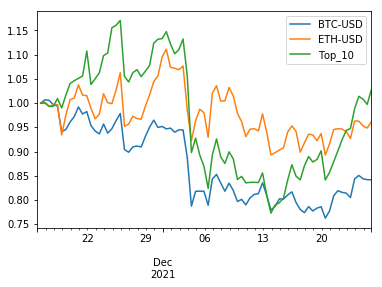

In [24]:
df_results.plot()

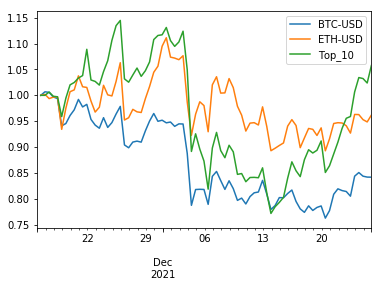

In [16]:
df_results.plot()

In [ ]:
df_results.plot()

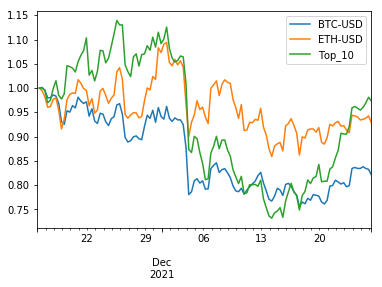

In [18]:
df_results.plot()

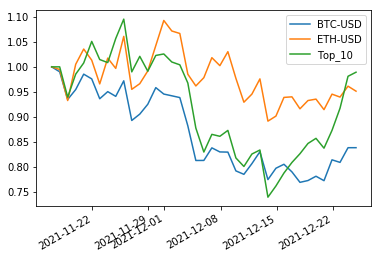

In [72]:
df_results.plot()

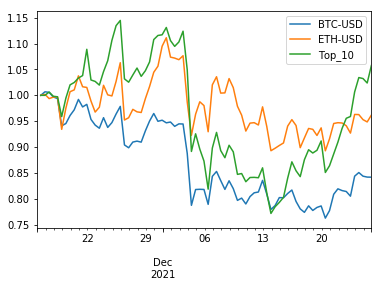

In [67]:
df_results.plot()

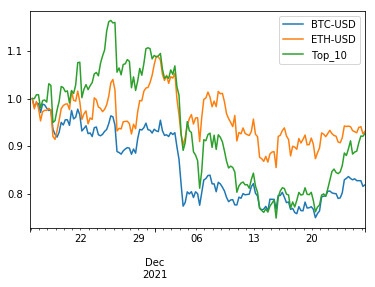

In [62]:
df_results.plot()

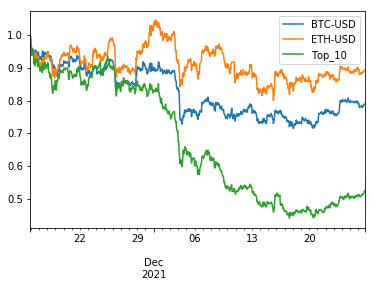

In [39]:
df_results.plot()

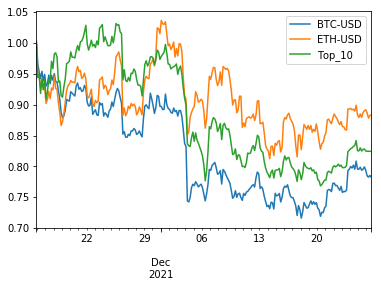

In [34]:
df_results.plot()

In [11]:
# Uitzoeken welke coins er steeds gekozen worden
# Uitzoeken hoe de yfinance package werkt. Mogelijk kan ik de marketcap per coin per week achterhalen voor een zuivere test.

# Kan biased zijn omdat de spike van iedere coin is meegenomen. De huidige top 10 is altijd dynamisch. 
# V.B. De ADA zat in 2017 niet in de top 10, maar in dit model is wel de hele geschiedenis van ADA meegenomen.
# Dat geeft een vertekend beeld. Dit model kan alleen op korte termijn worden getest. 
# Er bestaat nog steeds kans dat het beter presteerd dan BTC en ETH.
# Voor een eerlijke test hebben we de historical market cap nodig.


In [12]:
# data = yf.download('BTC-USD', interval='1d', start="2017-01-01", end="2021-12-01")
# data

In [13]:
# https://www.cryptodatadownload.com/data/
# https://itnext.io/getting-started-with-ccxt-crypto-exchange-library-and-python-93175d5a898d


In [14]:
# pd.read_csv('data/ETH-USD.csv')

In [15]:
# (4631-8)/8

In [16]:
# Next steps
# Meer coin data inlezen (aanpassen van get_top_crypto functie of data pakken van Coinmarketcap)
# Wekelijkse picks filteren op ranking van marketcap van die maand. 
# Als de top1 picks van die week in de top 10 vd maand zitten, dan mag het geselecteerd worden. 
# Anders niet en schuiven we op naar de volgende token.
# Code zo algemeen mogelijk zodat we dit later ook kunnen testen voor top 200 etc.